<a href="https://colab.research.google.com/github/AlexandreBourrieau/ML/blob/main/Carnets%20Jupyter/S%C3%A9ries%20temporelles/Reseau_GRU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Dans ce carnet nous allons mettre en place un modèle à réseau de neurones récurrent de type GRU (Gate Recurrent Unit) pour réaliser des prédictions sur notre série temporelle.

In [1]:
import tensorflow as tf
from tensorflow import keras

import numpy as np
import matplotlib.pyplot as plt

# Création de la série temporelle

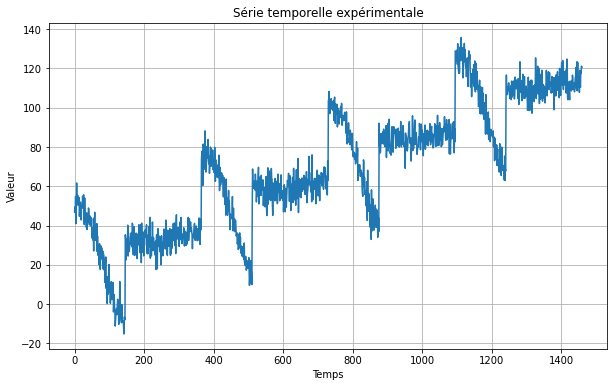

In [2]:
# Fonction permettant d'afficher une série temporelle
def affiche_serie(temps, serie, format="-", debut=0, fin=None, label=None):
    plt.plot(temps[debut:fin], serie[debut:fin], format, label=label)
    plt.xlabel("Temps")
    plt.ylabel("Valeur")
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)

# Fonction permettant de créer une tendance
def tendance(temps, pente=0):
    return pente * temps

# Fonction permettant de créer un motif
def motif_periodique(instants):
    return (np.where(instants < 0.4,                            # Si les instants sont < 0.4
                    np.cos(instants * 2 * np.pi),               # Alors on retourne la fonction cos(2*pi*t)
                    1 / np.exp(3 * instants)))                  # Sinon, on retourne la fonction exp(-3t)

# Fonction permettant de créer une saisonnalité avec un motif
def saisonnalite(temps, periode, amplitude=1, phase=0):
    """Répétition du motif sur la même période"""
    instants = ((temps + phase) % periode) / periode            # Mapping du temps =[0 1 2 ... 1460] => instants = [0.0 ... 1.0]
    return amplitude * motif_periodique(instants)

# Fonction permettant de générer du bruit gaussien N(0,1)
def bruit_blanc(temps, niveau_bruit=1, graine=None):
    rnd = np.random.RandomState(graine)
    return rnd.randn(len(temps)) * niveau_bruit

# Création de la série temporelle
temps = np.arange(4 * 365)                # temps = [0 1 2 .... 4*365] = [0 1 2 .... 1460]
amplitude = 40                            # Amplitude de la la saisonnalité
niveau_bruit = 5                          # Niveau du bruit
offset = 10                               # Offset de la série

serie = offset + tendance(temps, 0.07) + saisonnalite(temps, periode=365, amplitude=amplitude) + bruit_blanc(temps,niveau_bruit,graine=40)

plt.figure(figsize=(10, 6))
affiche_serie(temps,serie)
plt.title('Série temporelle expérimentale')
plt.show()

# Préparation des données X et Y

In [3]:
# Fonction permettant de créer un dataset à partir des données de la série temporelle
# au format X(X1,X2,...Xn) / Y(Y1,Y2,...,Yn)
# X sont les données d'entrées du réseau
# Y sont les labels

def prepare_dataset_XY(serie, taille_fenetre, batch_size, buffer_melange):
  dataset = tf.data.Dataset.from_tensor_slices(serie)
  dataset = dataset.window(taille_fenetre+1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda x: x.batch(taille_fenetre + 1))
  dataset = dataset.shuffle(buffer_melange).map(lambda x: (x[:-1], x[-1:]))
  dataset = dataset.batch(batch_size,drop_remainder=True).prefetch(1)
  return dataset

**1. Séparation des données en données pour l'entrainement et la validation**

<img src="https://github.com/AlexandreBourrieau/ML/blob/main/Carnets%20Jupyter/Images/Series/illustration1.png?raw=true" width="600">  

In [4]:
temps_separation = 1000

# Extraction des temps et des données d'entrainement
temps_entrainement = temps[:temps_separation]
x_entrainement = serie[:temps_separation]

# Exctraction des temps et des données de valiadation
temps_validation = temps[temps_separation:]
x_validation = serie[temps_separation:]

**2. Préparation des données X et des labels Y**

On commence par créer notre dataset à partir de la série (remarque : les valeurs ci-dessous sont en réalité mélangées) :

<img src="https://github.com/AlexandreBourrieau/ML/blob/main/Carnets%20Jupyter/S%C3%A9ries%20temporelles/images/split_XY_2.png?raw=true" width="1200"> 

In [5]:
# Définition des caractéristiques du dataset que l'on souhaite créer
taille_fenetre = 20
batch_size = 32
buffer_melange = 1000

# Création du dataset X,Y
dataset = prepare_dataset_XY(x_entrainement,taille_fenetre,batch_size,buffer_melange)

# Création du dataset X,Y de validation
dataset_Val = prepare_dataset_XY(x_validation,taille_fenetre,batch_size,buffer_melange)

# Création du modèle simple couche GRU

**1. Création du réseau et adaptation des formats d'entrée et de sortie**

Le réseau que nous allons mettre en place est un réseau de neurones récurrent, composé de :
  - Une couche d'entrée récurrente de type GRU à 40 neurones, de type séquence vers vecteur
  - Une couche de sortie dense avec 1 neurone

Pour adapter les données en entrée et en sortie du réseau au format attendu, nous allons utiliser une [couche de type lambda](https://keras.io/api/layers/core_layers/lambda/) avec Keras. Ce type de couche nous permet d'intégrer une fonction spécifique en tant que couche dans notre réseau de neurone.

- En entrée de la première couche récurrente, le format attendu est de type : [batch_size, #instants, #dims].   
Le **format d'entrée attendu est donc [None,None,1]** car notre série temporelle est de type univariée, qu'on souhaite pouvoir traiter une séquence infinie, et que le batch size est géré automatiquement par tensorflow.  
Il faut donc en entrée transformer le format [taille_fenetre, 1] vers le format [None, None, 1].  

- En sortie de la deuxième couche récurrente, le format est de type [batch_size, #instants, #neurones]. Il sera de type [None, None, 40].  
- La couche dense possède un seul neurone. En **sortie de la couche dense, le format est de type [None, None, 1]**.

Sous Keras, nous allons utiliser une couche récurrente de type GRU avec la classe [GRU](https://keras.io/api/layers/recurrent_layers/gru/). En sortie, la fonction d'activation par défaut est de type `tanh` qui sort une sortie comprise entre [-1,1]. Comme notre série possède des valeurs autour de 100, nous allons faire en sorte d'étendre la plage des valeurs en sortie de la couche dense en les multipliant par 100.

Sous forme de shéma, notre réseau est donc le suivant :


<img src="https://github.com/AlexandreBourrieau/ML/blob/main/Carnets%20Jupyter/S%C3%A9ries%20temporelles/images/GRU_1.png?raw=true" width="1200"> 

Pour insérer une dimension de type `None` au format de l'entrée, on utilise la méthode [expand_dims](https://www.tensorflow.org/api_docs/python/tf/expand_dims) de tensorflow. 

In [17]:
# Remise à zéro de tous les états générés par Keras
tf.keras.backend.clear_session()

In [18]:
# Fonction de la couche lambda d'entrée
def Traitement_Entrees(x):
  return tf.expand_dims(x,axis=-1)

# Fonction dela couche lambda de sortie
def Traitement_Sorties(x):
  return(x*100.0)

model = tf.keras.models.Sequential()
model.add(tf.keras.Input(shape=(None,)))
model.add(tf.keras.layers.Lambda(Traitement_Entrees))
model.add(tf.keras.layers.GRU(40))
model.add(tf.keras.layers.Dense(1))
model.add(tf.keras.layers.Lambda(Traitement_Sorties))

model.save_weights('model_initial.h5')

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda (Lambda)              (None, None, 1)           0         
_________________________________________________________________
gru (GRU)                    (None, 40)                5160      
_________________________________________________________________
dense (Dense)                (None, 1)                 41        
_________________________________________________________________
lambda_1 (Lambda)            (None, 1)                 0         
Total params: 5,201
Trainable params: 5,201
Non-trainable params: 0
_________________________________________________________________


**2. Optimisation du taux d'apprentissage**

In [ ]:
# Remise à zéro de tous les états générés par Keras
tf.keras.backend.clear_session()


In [19]:
# Définition de la fonction de régulation du taux d'apprentissage
def RegulationTauxApprentissage(periode, taux):
  return 1e-8*10**(periode/20)

# Définition de l'optimiseur à utiliser
optimiseur=tf.keras.optimizers.Adam()

# Utilisation de la méthode ModelCheckPoint
CheckPoint = tf.keras.callbacks.ModelCheckpoint("poids.hdf5", monitor='loss', verbose=1, save_best_only=True, save_weights_only = True, mode='auto', save_freq='epoch')

# Compile le modèle
model.compile(loss=tf.keras.losses.Huber(), optimizer=optimiseur, metrics="mae")

# Entraine le modèle en utilisant notre fonction personnelle de régulation du taux d'apprentissage
historique = model.fit(dataset,epochs=200,verbose=1, callbacks=[tf.keras.callbacks.LearningRateScheduler(RegulationTauxApprentissage), CheckPoint])

Epoch 1/200
30/30 [==============================] - 2s 8ms/step - loss: 41.5970 - mae: 42.0967

Epoch 00001: loss improved from inf to 40.67970, saving model to poids.hdf5
Epoch 2/200
30/30 [==============================] - 0s 10ms/step - loss: 40.4606 - mae: 40.9603

Epoch 00002: loss did not improve from 40.67970
Epoch 3/200
30/30 [==============================] - 0s 9ms/step - loss: 40.6430 - mae: 41.1424

Epoch 00003: loss did not improve from 40.67970
Epoch 4/200
30/30 [==============================] - 0s 8ms/step - loss: 40.4137 - mae: 40.9134

Epoch 00004: loss improved from 40.67970 to 40.58350, saving model to poids.hdf5
Epoch 5/200
30/30 [==============================] - 0s 9ms/step - loss: 40.3832 - mae: 40.8831

Epoch 00005: loss did not improve from 40.58350
Epoch 6/200
30/30 [==============================] - 0s 8ms/step - loss: 40.8411 - mae: 41.3405

Epoch 00006: loss did not improve from 40.58350
Epoch 7/200
30/30 [==============================] - 0s 8ms/step - l

Text(0.5, 1.0, "Evolution de l'erreur en fonction du taux d'apprentissage")

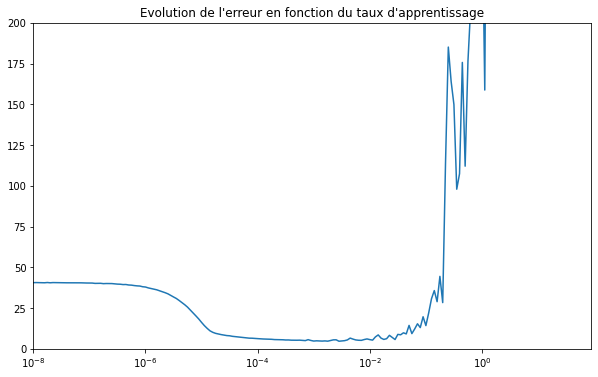

In [20]:
# Construit un vecteur avec les valeurs du taux d'apprentissage à chaque période 
taux = 1e-8*(10**(np.arange(200)/20))

# Affiche l'erreur en fonction du taux d'apprentissage
plt.figure(figsize=(10, 6))
plt.semilogx(taux,historique.history["loss"])
plt.axis([ taux[0], taux[199], 0, 200])
plt.title("Evolution de l'erreur en fonction du taux d'apprentissage")

**3. Entrainement du modèle**

In [ ]:
# Remise à zéro des états du modèle
tf.keras.backend.clear_session()

In [21]:
# Chargement des poids sauvegardés
model.load_weights("poids.hdf5")

In [23]:
# Définition de l'optimiseur à utiliser
optimiseur=tf.keras.optimizers.Adam(lr=1e-3)

# Utilisation de la méthode ModelCheckPoint
CheckPoint = tf.keras.callbacks.ModelCheckpoint("poids.hdf5", monitor='val_loss', verbose=1, save_best_only=True, save_weights_only = True, mode='auto', save_freq='epoch')

# Compile le modèle
model.compile(loss=tf.keras.losses.Huber(), optimizer=optimiseur,metrics="mae")

# Entraine le modèle
historique = model.fit(dataset,validation_data=dataset_Val, epochs=500,verbose=1, callbacks=[CheckPoint])

Epoch 1/500
30/30 [==============================] - 3s 30ms/step - loss: 4.5978 - mae: 5.0723 - val_loss: 7.0102 - val_mae: 7.4916

Epoch 00001: val_loss improved from inf to 7.01025, saving model to poids.hdf5
Epoch 2/500
30/30 [==============================] - 0s 13ms/step - loss: 4.6738 - mae: 5.1520 - val_loss: 6.3885 - val_mae: 6.8770

Epoch 00002: val_loss improved from 7.01025 to 6.38852, saving model to poids.hdf5
Epoch 3/500
30/30 [==============================] - 1s 14ms/step - loss: 4.6290 - mae: 5.1043 - val_loss: 7.0976 - val_mae: 7.5811

Epoch 00003: val_loss did not improve from 6.38852
Epoch 4/500
30/30 [==============================] - 0s 13ms/step - loss: 4.2561 - mae: 4.7296 - val_loss: 6.3095 - val_mae: 6.7979

Epoch 00004: val_loss improved from 6.38852 to 6.30954, saving model to poids.hdf5
Epoch 5/500
30/30 [==============================] - 0s 13ms/step - loss: 4.4696 - mae: 4.9440 - val_loss: 6.2910 - val_mae: 6.7771

Epoch 00005: val_loss improved from 6.3

Text(0.5, 1.0, "Evolution de l'erreur en fonction de la période")

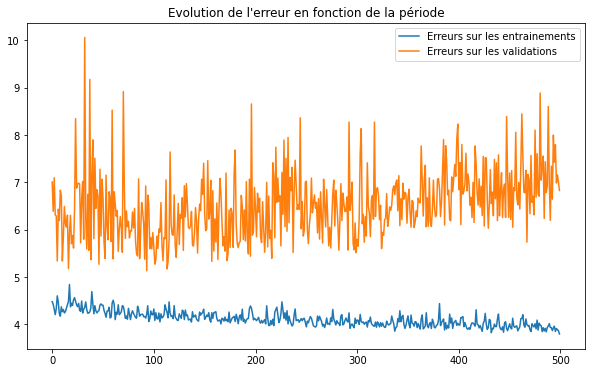

In [24]:
erreur_entrainement = historique.history["loss"]
erreur_validation = historique.history["val_loss"]

# Affiche l'erreur en fonction de la période
plt.figure(figsize=(10, 6))
plt.plot(np.arange(0,len(erreur_entrainement)),erreur_entrainement, label="Erreurs sur les entrainements")
plt.plot(np.arange(0,len(erreur_entrainement)),erreur_validation, label ="Erreurs sur les validations")
plt.legend()

plt.title("Evolution de l'erreur en fonction de la période")

Text(0.5, 1.0, "Evolution de l'erreur en fonction de la période")

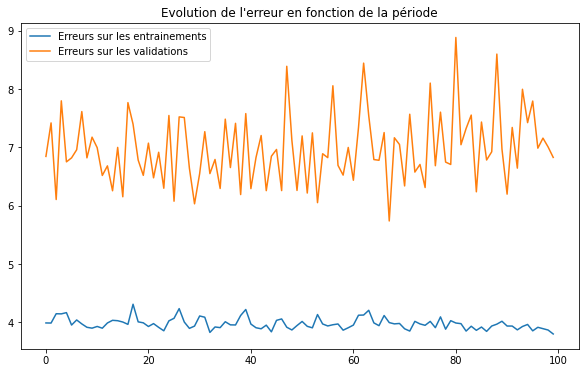

In [25]:
erreur_entrainement = historique.history["loss"]
erreur_validation = historique.history["val_loss"]

# Affiche l'erreur en fonction de la période
plt.figure(figsize=(10, 6))
plt.plot(np.arange(0,len(erreur_entrainement[400:500])),erreur_entrainement[400:500], label="Erreurs sur les entrainements")
plt.plot(np.arange(0,len(erreur_entrainement[400:500])),erreur_validation[400:500], label ="Erreurs sur les validations")
plt.legend()

plt.title("Evolution de l'erreur en fonction de la période")

**4. Prédictions**

Puisque le format d'entrée permet de prendre des séquences infinies, nous pouvons entrer des séquences de n'importe quelle taille :

In [26]:
# Charge les meilleurs poids
model.load_weights("poids.hdf5")

In [ ]:
X = np.reshape(serie[0:20],(1,20))
model.predict(X)

In [27]:
taille_fenetre = 20

# Création d'une liste vide pour recevoir les prédictions
predictions = []

# Calcul des prédiction pour chaque groupe de 20 valeurs consécutives de la série
# dans l'intervalle de validation
for t in temps[temps_separation:-taille_fenetre]:
    X = np.reshape(serie[t:t+taille_fenetre],(1,taille_fenetre))
    predictions.append(model.predict(X))

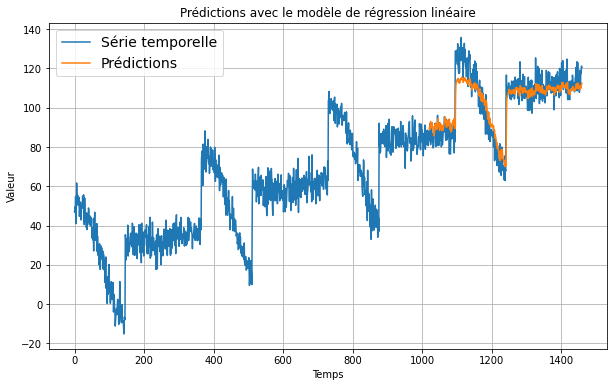

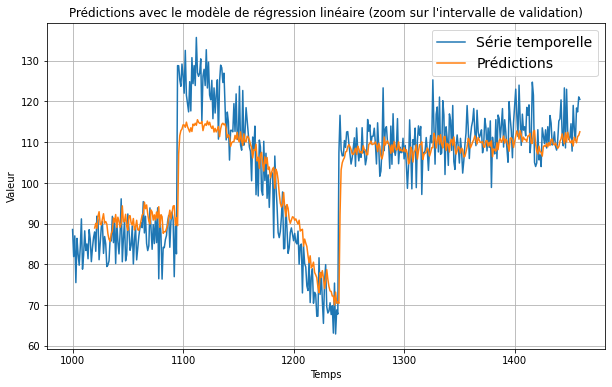

In [28]:
# Affiche la série et les prédictions
plt.figure(figsize=(10, 6))
affiche_serie(temps,serie,label="Série temporelle")
affiche_serie(temps[temps_separation+taille_fenetre:],np.asarray(predictions)[:,0,0],label="Prédictions")
plt.title('Prédictions avec le modèle de régression linéaire')
plt.show()

# Zoom sur l'intervalle de validation
plt.figure(figsize=(10, 6))
affiche_serie(temps[temps_separation:],serie[temps_separation:],label="Série temporelle")
affiche_serie(temps[temps_separation+taille_fenetre:],np.asarray(predictions)[:,0,0],label="Prédictions")
plt.title("Prédictions avec le modèle de régression linéaire (zoom sur l'intervalle de validation)")
plt.show()

In [30]:
# Calcule de l'erreur quadratique moyenne et de l'erreur absolue moyenne 

mae = tf.keras.metrics.mean_absolute_error(serie[temps_separation+taille_fenetre:],np.asarray(predictions)[:,0,0]).numpy()
mse = tf.keras.metrics.mean_squared_error(serie[temps_separation+taille_fenetre:],np.asarray(predictions)[:,0,0]).numpy()

print(mae)
print(mse)

5.6176653
56.10615


# Création du modèle double couche GRU

**1. Construction du modèle**

Sous forme de shéma, notre réseau est donc le suivant :

<img src="https://github.com/AlexandreBourrieau/ML/blob/main/Carnets%20Jupyter/S%C3%A9ries%20temporelles/images/GRU_2.png?raw=true" width="1200"> 

In [6]:
# Remise à zéro de tous les états générés par Keras
tf.keras.backend.clear_session()

# Fonction de la couche lambda d'entrée
def Traitement_Entrees(x):
  return tf.expand_dims(x,axis=-1)

# Fonction dela couche lambda de sortie
def Traitement_Sorties(x):
  return(x*100.0)

model = tf.keras.models.Sequential()
model.add(tf.keras.Input(shape=(None,)))
model.add(tf.keras.layers.Lambda(Traitement_Entrees))
model.add(tf.keras.layers.GRU(40,return_sequences=True))
model.add(tf.keras.layers.GRU(40))
model.add(tf.keras.layers.Dense(1))
model.add(tf.keras.layers.Lambda(Traitement_Sorties))

model.save_weights('model_initial.h5')

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda (Lambda)              (None, None, 1)           0         
_________________________________________________________________
gru (GRU)                    (None, None, 40)          5160      
_________________________________________________________________
gru_1 (GRU)                  (None, 40)                9840      
_________________________________________________________________
dense (Dense)                (None, 1)                 41        
_________________________________________________________________
lambda_1 (Lambda)            (None, 1)                 0         
Total params: 15,041
Trainable params: 15,041
Non-trainable params: 0
_________________________________________________________________


**2. Optimisation du taux d'apprentissage**

In [7]:
# Définition de la fonction de régulation du taux d'apprentissage
def RegulationTauxApprentissage(periode, taux):
  return 1e-8*10**(periode/20)

# Définition de l'optimiseur à utiliser
optimiseur=tf.keras.optimizers.Adam()


# Utilisation de la méthode ModelCheckPoint
CheckPoint = tf.keras.callbacks.ModelCheckpoint("poids.hdf5", monitor='loss', verbose=1, save_best_only=True, save_weights_only = True, mode='auto', save_freq='epoch')

# Compile le modèle
model.compile(loss=tf.keras.losses.Huber(), optimizer=optimiseur, metrics="mae")

# Entraine le modèle en utilisant notre fonction personnelle de régulation du taux d'apprentissage
historique = model.fit(dataset,epochs=200,verbose=1, callbacks=[tf.keras.callbacks.LearningRateScheduler(RegulationTauxApprentissage), CheckPoint])

Epoch 1/200
30/30 [==============================] - 4s 18ms/step - loss: 95.8656 - mae: 96.3652

Epoch 00001: loss improved from inf to 98.44791, saving model to poids.hdf5
Epoch 2/200
30/30 [==============================] - 1s 14ms/step - loss: 99.8984 - mae: 100.3982

Epoch 00002: loss improved from 98.44791 to 98.37083, saving model to poids.hdf5
Epoch 3/200
30/30 [==============================] - 1s 16ms/step - loss: 98.1133 - mae: 98.6131

Epoch 00003: loss did not improve from 98.37083
Epoch 4/200
30/30 [==============================] - 1s 14ms/step - loss: 96.9930 - mae: 97.4928

Epoch 00004: loss did not improve from 98.37083
Epoch 5/200
30/30 [==============================] - 1s 16ms/step - loss: 97.4423 - mae: 97.9423

Epoch 00005: loss improved from 98.37083 to 98.19946, saving model to poids.hdf5
Epoch 6/200
30/30 [==============================] - 1s 15ms/step - loss: 97.7260 - mae: 98.2253

Epoch 00006: loss did not improve from 98.19946
Epoch 7/200
30/30 [==========

Text(0.5, 1.0, "Evolution de l'erreur en fonction du taux d'apprentissage")

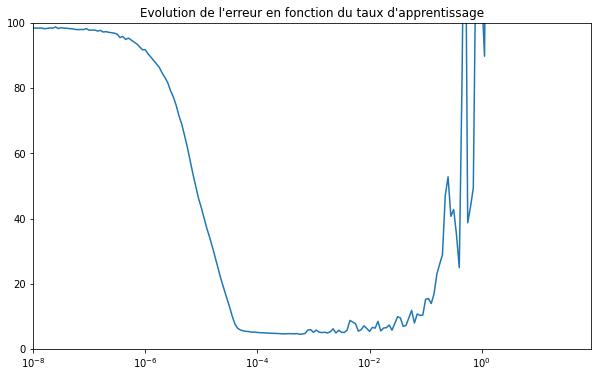

In [8]:
# Construit un vecteur avec les valeurs du taux d'apprentissage à chaque période 
taux = 1e-8*(10**(np.arange(200)/20))

# Affiche l'erreur en fonction du taux d'apprentissage
plt.figure(figsize=(10, 6))
plt.semilogx(taux,historique.history["loss"])
plt.axis([taux[0], taux[199], 0, 100])
plt.title("Evolution de l'erreur en fonction du taux d'apprentissage")

**3. Entrainement du modèle**

In [10]:
# Remise à zéro des états du modèle
tf.keras.backend.clear_session()

# Chargement des poids sauvegardés
model.load_weights("poids.hdf5")

# Définition de l'optimiseur à utiliser
optimiseur=tf.keras.optimizers.Adam(lr=1e-3)

# Utilisation de la méthode ModelCheckPoint
CheckPoint = tf.keras.callbacks.ModelCheckpoint("poids.hdf5", monitor='val_loss', verbose=1, save_best_only=True, save_weights_only = True, mode='auto', save_freq='epoch')

# Compile le modèle
model.compile(loss=tf.keras.losses.Huber(), optimizer=optimiseur,metrics="mae")

# Entraine le modèle
historique = model.fit(dataset,validation_data=dataset_Val, epochs=500,verbose=1, callbacks=[CheckPoint])

Epoch 1/500
30/30 [==============================] - 5s 51ms/step - loss: 9.1392 - mae: 9.6279 - val_loss: 6.2745 - val_mae: 6.7537

Epoch 00001: val_loss improved from inf to 6.27453, saving model to poids.hdf5
Epoch 2/500
30/30 [==============================] - 1s 19ms/step - loss: 4.7862 - mae: 5.2655 - val_loss: 5.4630 - val_mae: 5.9454

Epoch 00002: val_loss improved from 6.27453 to 5.46303, saving model to poids.hdf5
Epoch 3/500
30/30 [==============================] - 1s 20ms/step - loss: 4.8845 - mae: 5.3690 - val_loss: 5.4061 - val_mae: 5.8892

Epoch 00003: val_loss improved from 5.46303 to 5.40607, saving model to poids.hdf5
Epoch 4/500
30/30 [==============================] - 1s 21ms/step - loss: 5.1380 - mae: 5.6223 - val_loss: 10.8277 - val_mae: 11.3210

Epoch 00004: val_loss did not improve from 5.40607
Epoch 5/500
30/30 [==============================] - 1s 20ms/step - loss: 5.6771 - mae: 6.1574 - val_loss: 5.0721 - val_mae: 5.5469

Epoch 00005: val_loss improved from 5

Text(0.5, 1.0, "Evolution de l'erreur en fonction de la période")

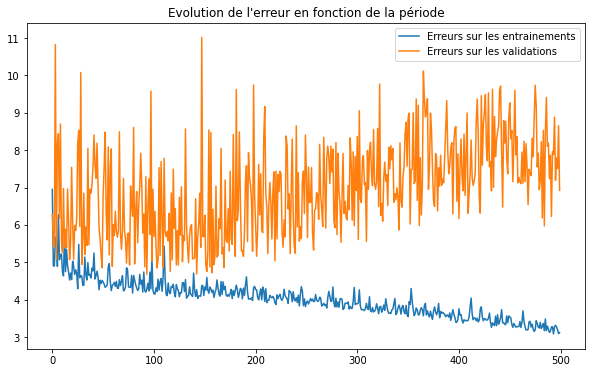

In [11]:
erreur_entrainement = historique.history["loss"]
erreur_validation = historique.history["val_loss"]

# Affiche l'erreur en fonction de la période
plt.figure(figsize=(10, 6))
plt.plot(np.arange(0,len(erreur_entrainement)),erreur_entrainement, label="Erreurs sur les entrainements")
plt.plot(np.arange(0,len(erreur_entrainement)),erreur_validation, label ="Erreurs sur les validations")
plt.legend()

plt.title("Evolution de l'erreur en fonction de la période")

Text(0.5, 1.0, "Evolution de l'erreur en fonction de la période")

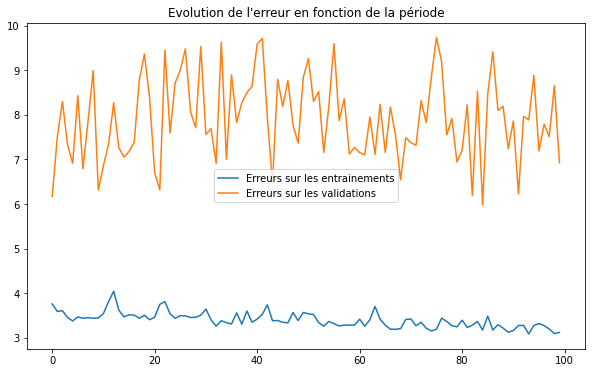

In [12]:
erreur_entrainement = historique.history["loss"]
erreur_validation = historique.history["val_loss"]

# Affiche l'erreur en fonction de la période
plt.figure(figsize=(10, 6))
plt.plot(np.arange(0,len(erreur_entrainement[400:500])),erreur_entrainement[400:500], label="Erreurs sur les entrainements")
plt.plot(np.arange(0,len(erreur_entrainement[400:500])),erreur_validation[400:500], label ="Erreurs sur les validations")
plt.legend()

plt.title("Evolution de l'erreur en fonction de la période")

**4. Prédictions**

In [13]:
# Charge les meilleurs poids
model.load_weights("poids.hdf5")

In [14]:
taille_fenetre = 20

# Création d'une liste vide pour recevoir les prédictions
predictions = []

# Calcul des prédiction pour chaque groupe de 20 valeurs consécutives de la série
# dans l'intervalle de validation
for t in temps[temps_separation:-taille_fenetre]:
    X = np.reshape(serie[t:t+taille_fenetre],(1,taille_fenetre))
    predictions.append(model.predict(X))

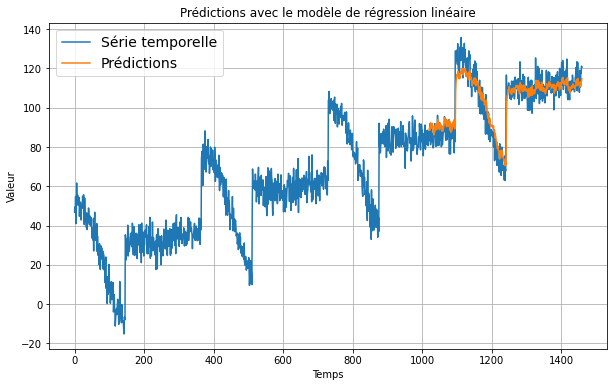

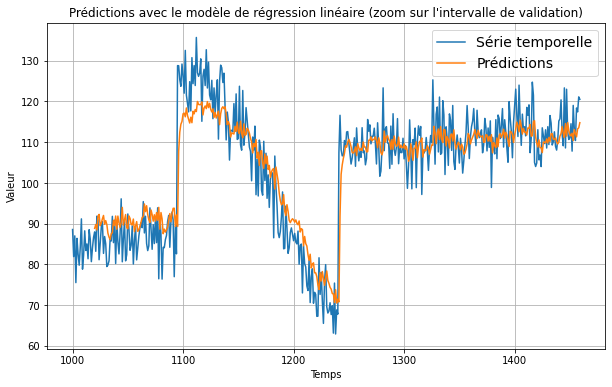

In [15]:
# Affiche la série et les prédictions
plt.figure(figsize=(10, 6))
affiche_serie(temps,serie,label="Série temporelle")
affiche_serie(temps[temps_separation+taille_fenetre:],np.asarray(predictions)[:,0,0],label="Prédictions")
plt.title('Prédictions avec le modèle de régression linéaire')
plt.show()

# Zoom sur l'intervalle de validation
plt.figure(figsize=(10, 6))
affiche_serie(temps[temps_separation:],serie[temps_separation:],label="Série temporelle")
affiche_serie(temps[temps_separation+taille_fenetre:],np.asarray(predictions)[:,0,0],label="Prédictions")
plt.title("Prédictions avec le modèle de régression linéaire (zoom sur l'intervalle de validation)")
plt.show()

In [16]:
# Calcule de l'erreur quadratique moyenne et de l'erreur absolue moyenne 

mae = tf.keras.metrics.mean_absolute_error(serie[temps_separation+taille_fenetre:],np.asarray(predictions)[:,0,0]).numpy()
mse = tf.keras.metrics.mean_squared_error(serie[temps_separation+taille_fenetre:],np.asarray(predictions)[:,0,0]).numpy()

print(mae)
print(mse)

5.239873
48.457527
